# Compare minimization algorithms
- no of iterations
- robustness for fuzzy inits

In [2]:
from read_ggp_run import *
from matplotlib.lines import Line2D

In [3]:
params_config =  {'mean_lambda': 'free',
                'gamma_lambda': 'free',
                'var_lambda': 'free',
                'mean_q': 'free',
                'gamma_q': 'free',
                'var_q':'free',
                'beta':'free',
                'var_x':'free',
                'var_g':'free',
                'var_dx':'free',
                'var_dg':'free'}


In [4]:
def compare_algos_iter(filebases, labels, xlabel, ylabel):
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    sizes = [40,30,25,20]
    fig, ax = plt.subplots()
    for i in range(20):
        plotting_list = [(f, c, s) for f,c,s in zip(filebases, colors, sizes)]
        for f, c, s in plotting_list:
            iter_file, _ = get_minimization_file(f.format(i,i), params_config)

            try:
                mini_data = read_iteration_process(iter_file)
                iterations = mini_data.to_numpy()[:,0].astype(int)[-1]
                ax.scatter(i, iterations, c=c, s=s)
            except Exception:
                pass

    ax.set_yscale('log')

    legend_elements = [Line2D([0],[0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) \
                            for l,c in zip(labels, colors)]

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    plt.show()


def compare_algos_ll(filebases, labels, xlabel, ylabel):
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    sizes = [40,30,25,20]
    fig, ax = plt.subplots()
    for i in range(20):
        plotting_list = [(f, c, s) for f,c,s in zip(filebases, colors, sizes)]
        for f, c, s in plotting_list:
            _, final_file = get_minimization_file(f.format(i,i), params_config)

            try:
                ll = pd.read_csv(final_file, skiprows=19, header=None)
                ll_max = float(ll.to_numpy()[1,1])
                ax.scatter(i, ll_max, c=c, s=s)
            except Exception:
                pass

    ax.ticklabel_format(style="plain", useOffset=False)
    # ax.set_ylim()

    legend_elements = [Line2D([0],[0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) \
                            for l,c in zip(labels, colors)]

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    plt.show()



In [5]:
all_out_dirs=["../data_2.0/log_params_test_n250_sizer/log_params_test_n250_sizer_{:d}/LN_COBYLA/log_params_test_n250_sizer_{:d}",
        "../data_2.0/log_params_test_n250_sizer/log_params_test_n250_sizer_{:d}/LN_COBYLA_log/log_params_test_n250_sizer_{:d}",
  "../data_2.0/log_params_test_n250_sizer/log_params_test_n250_sizer_{:d}/LN_COBYLA_log_low_tol/log_params_test_n250_sizer_{:d}",
  "../data_2.0/log_params_test_n250_sizer/log_params_test_n250_sizer_{:d}/LN_COBYLA_log_low_low_tol/log_params_test_n250_sizer_{:d}"]

all_labels = ["linear | tol=0.1",
         "log | tol=0.1", 
         'log | tol=0.01', 
         'log | tol=0.005']

indices = [0,1,3]
out_dirs = [all_out_dirs[i] for i in indices]
labels = [all_labels[i] for i in indices]

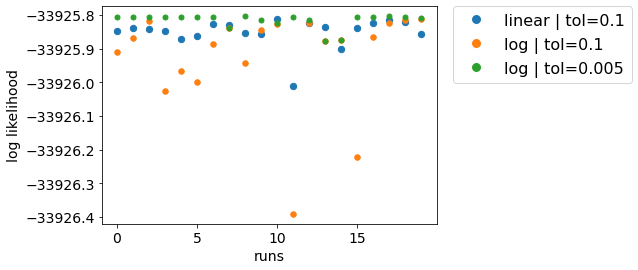

In [6]:
compare_algos_ll(out_dirs , labels , "runs", "log likelihood")

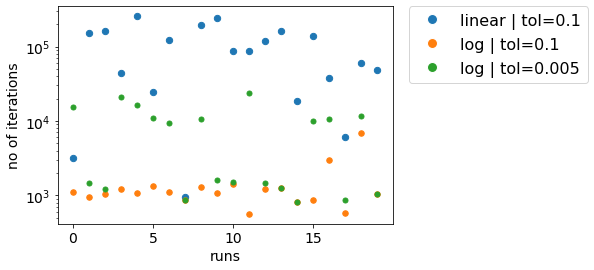

In [7]:
compare_algos_iter(out_dirs , labels , "runs", "no of iterations")

In [9]:
def plot_noisy_param_run(directory, sample, x_param_range, params_config, skip=0, cols=3, width=14, out_dir=None):
    no_params = len(params_config)
    rows = np.ceil(no_params/cols).astype(int)
    fig, axes = plt.subplots(rows, cols, figsize=(width,0.7*width/cols*rows))
    ax = axes.ravel()
    for i, k in enumerate(params_config.items()):
        n = 0
        while n < len(x_param_range):
            j = n + skip
            if out_dir == None:
                directory_j = directory.format(j)
                sample_j = sample.format(j)
                filebase = default_filebase(directory_j, sample_j) # default
            else:
                filebase = out_dir.format(j, j)
            minimization_iter_file, minimization_final_file = get_minimization_file(filebase, params_config)

            if os.path.isfile(minimization_final_file):
                parameters_settings = read_params_config(minimization_final_file)
                final = get_params_config(parameters_settings, k[0])["final"].values[0]
                init = get_params_config(parameters_settings, k[0])["init"].values[0]

                err_bar = float(pd.read_csv(minimization_final_file, skiprows=14)[k[0]].iloc[2])
                ax[i].errorbar(n, final, yerr=err_bar, color='tab:blue',  fmt='o', ms=3, 
                            label="deviation prediction")

                # ax[i].scatter(n, final, color="tab:blue")
                ax[i].scatter(n, init, color="tab:orange")
            n += 1

        # ax[i].ticklabel_format(style='sci', scilimits=(0,1), useOffset=False)
        ax[i].set_ylabel(k[0])
        ax[i].set_xlabel("run")

    for i in range(len(params_config), len(ax)):
        plt.delaxes(ax[i])
    plt.tight_layout()

    plt.show()

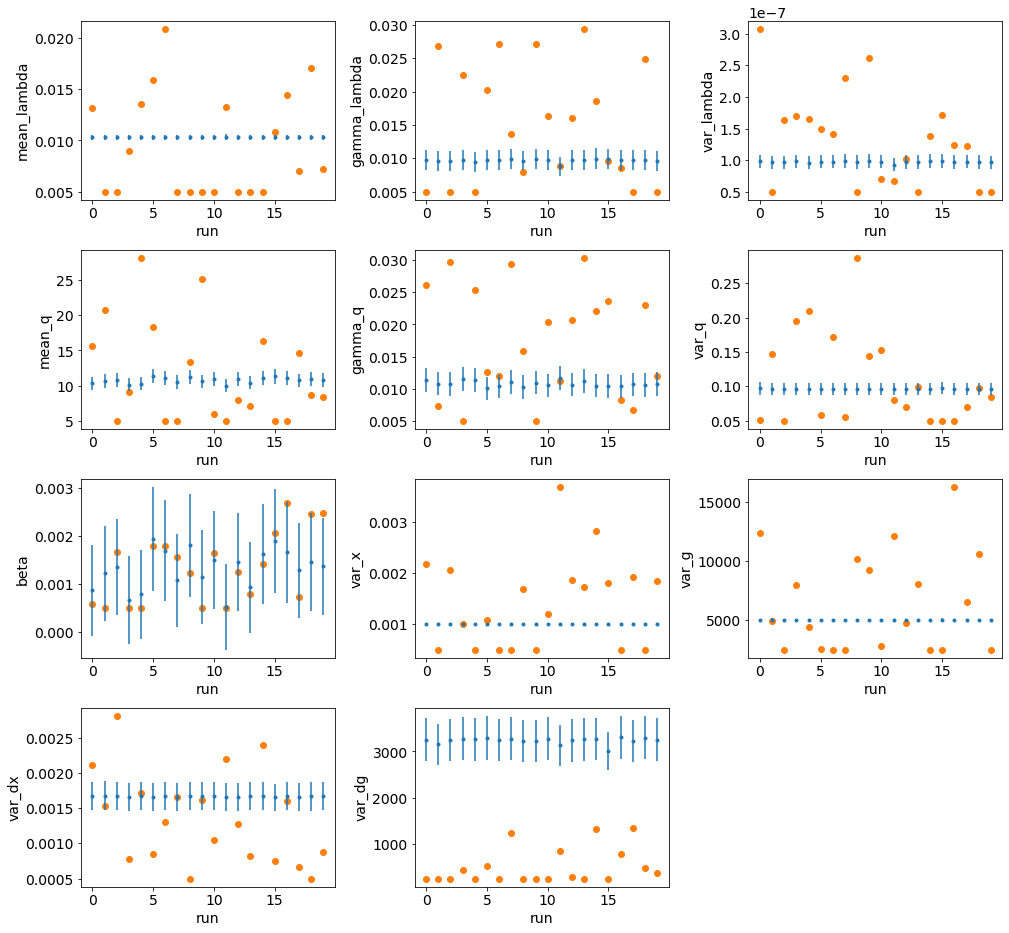

In [10]:
noise_levels = np.arange(20)
for out in [all_out_dirs[1]]:
    plot_noisy_param_run('', '', noise_levels, params_config , skip=0, cols=3, width=14, out_dir=out)




In [11]:

def plot_minimization(filenames, plot_file=None, labels=None, log=None, title=None):
    """ plots log likelihood vs number of iterations """

    fig, ax = plt.subplots(figsize=(10,7))
    for i, filename in enumerate(filenames):
        mini_data = read_iteration_process(filename)
        iterations = mini_data.to_numpy()[:,0].astype(int)
        ll = mini_data.to_numpy()[:,1]
        ax.plot(iterations, ll)
        if labels != None:
            label = labels[i]+", iteration: {:d}, log likelihood: {:.2f}".format(iterations[-1], ll[-1])
        else:
            label = "iteration: {:d}, log likelihood: {:.2f}".format(iterations[-1], ll[-1])
        ax.scatter(iterations[-1], ll[-1], label=label)
    
    ax.legend()
    ax.set_xlabel("iterations")
    ax.set_ylabel("log likelihood")
    if log == 'x':
        plt.xscale('log')
    if log == True:
        plt.xscale('log')
        plt.yscale('log')

    if title != None:
        ax.set_title(title)
    ax.set_xlim(left=100)
    ax.set_ylim(-33980, -33920)

    if plot_file != None:
        plt.savefig(plot_file + '_minimization.pdf')
    plt.show()



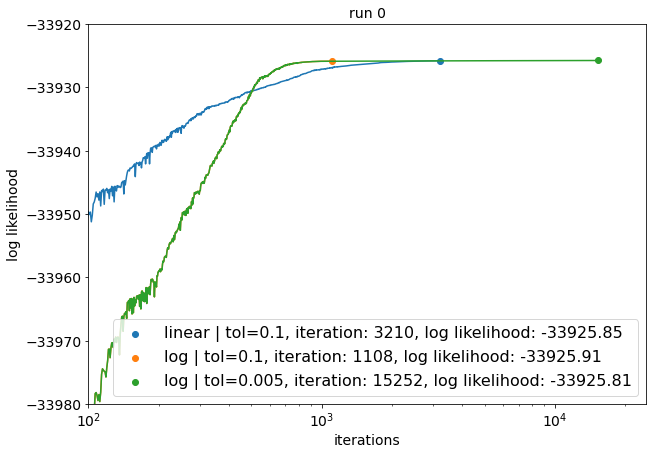

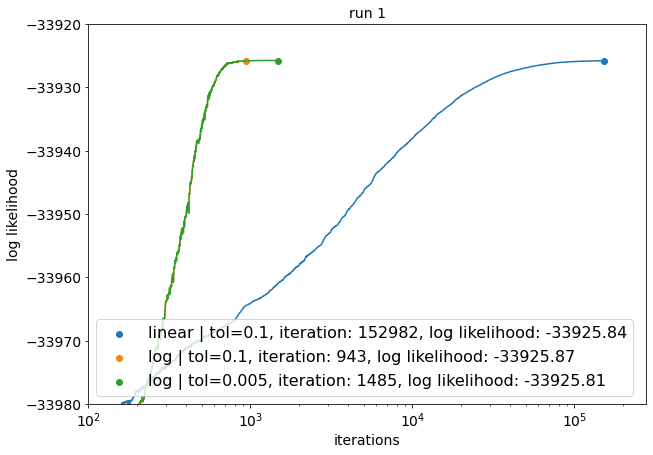

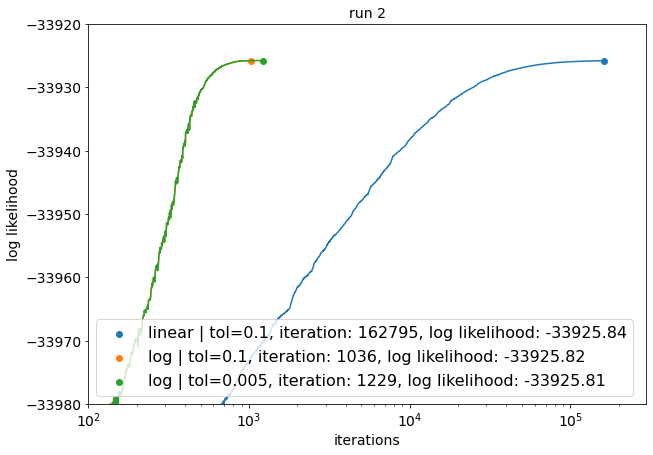

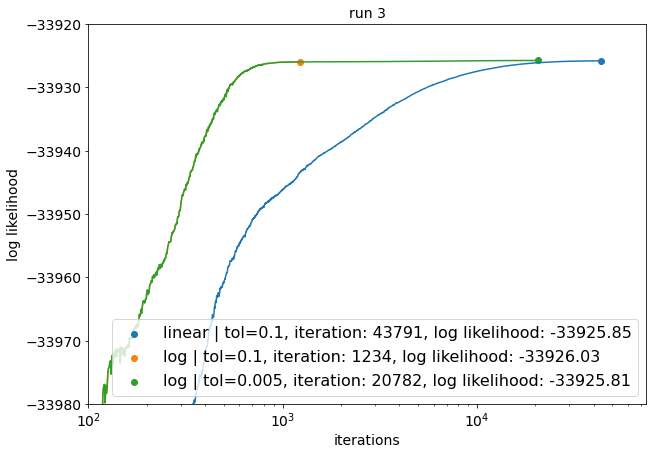

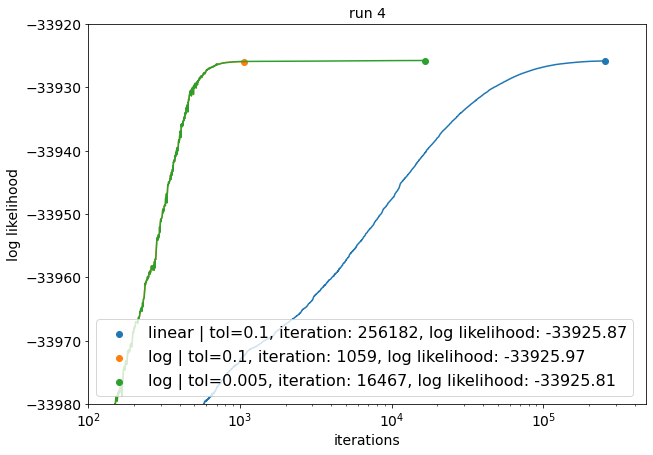

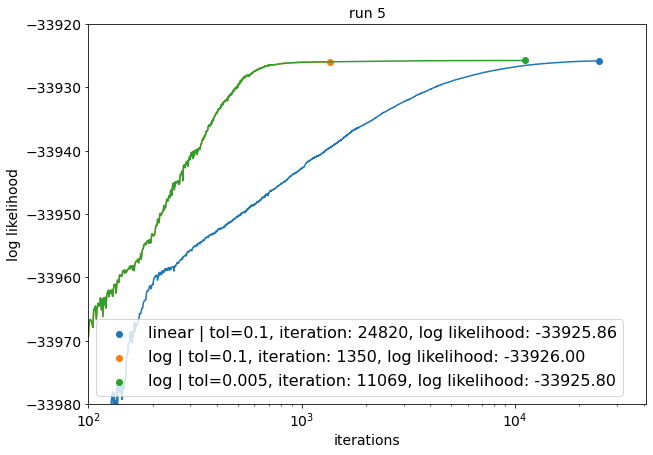

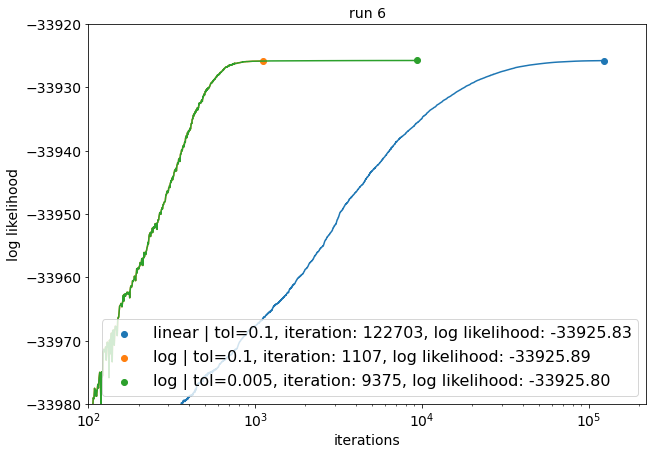

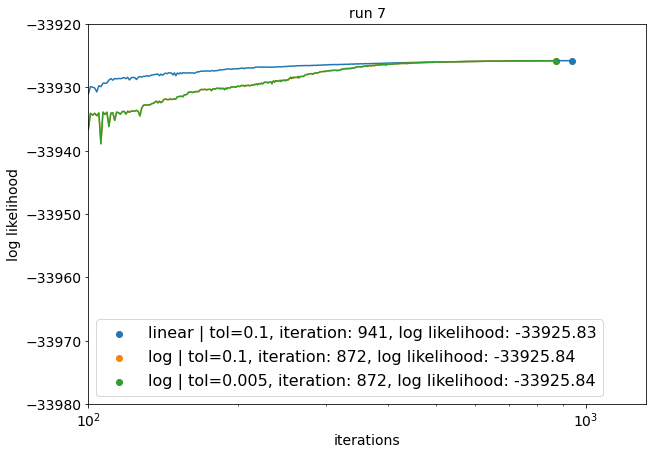

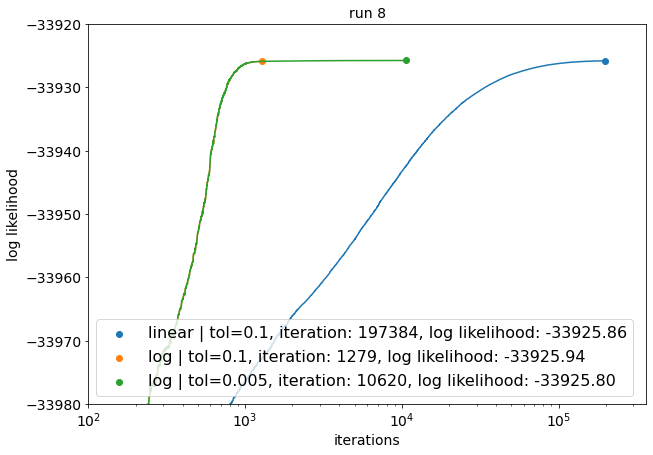

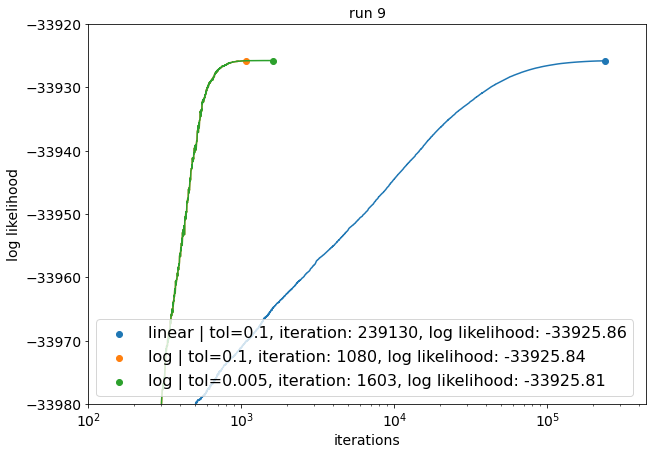

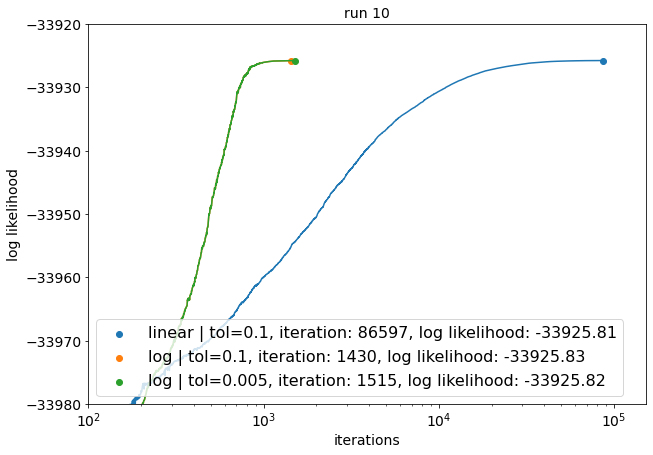

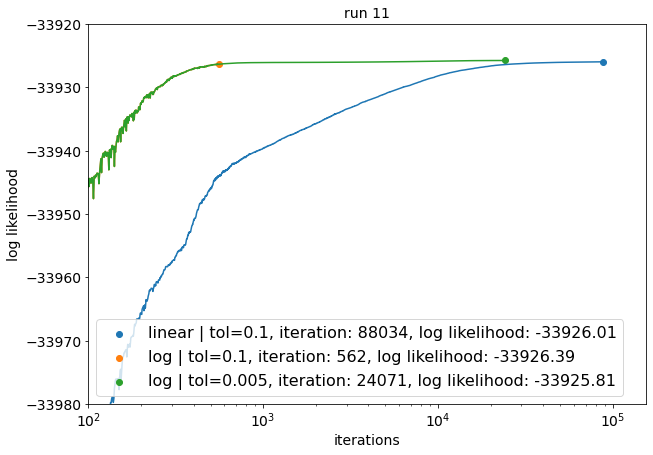

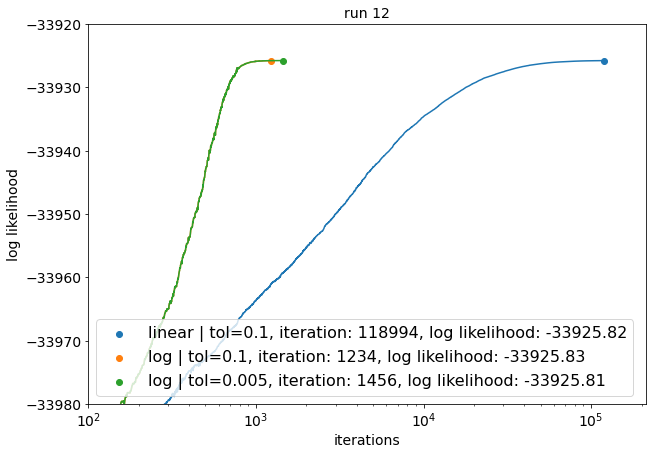

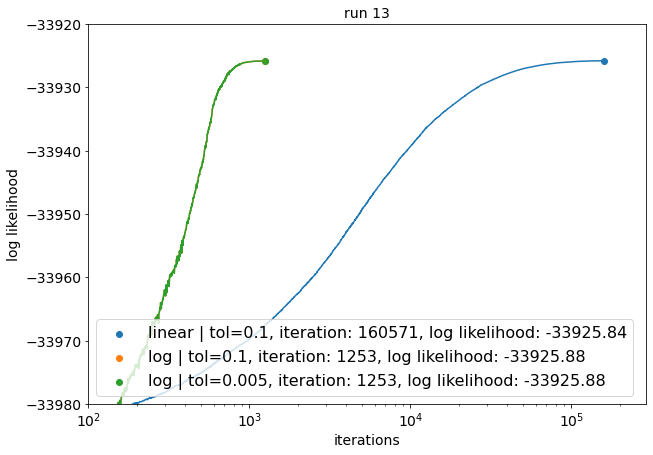

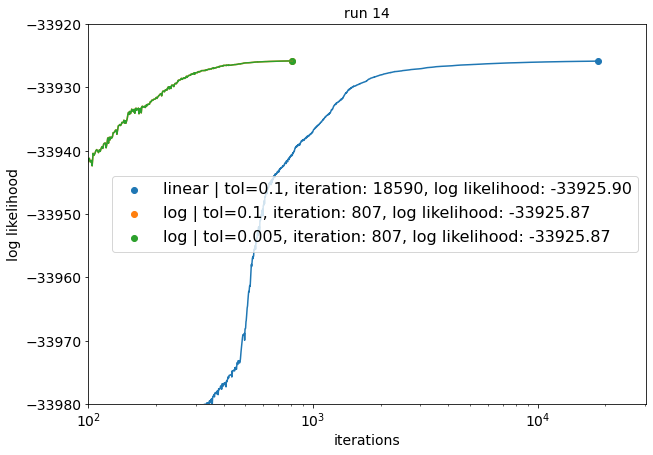

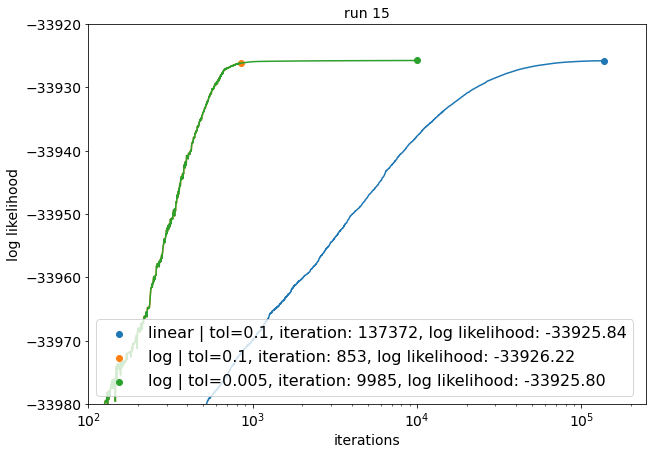

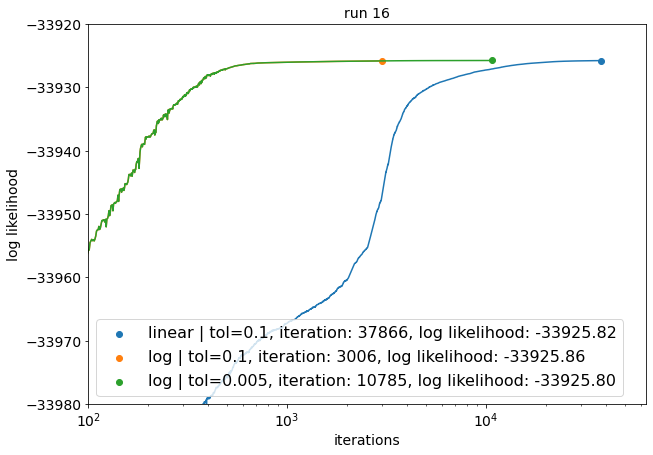

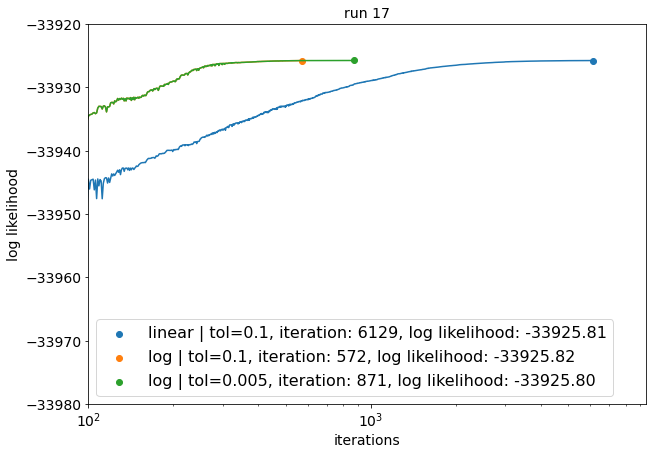

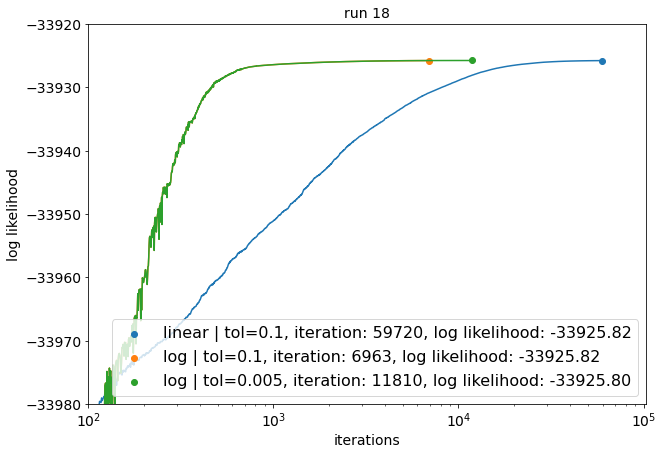

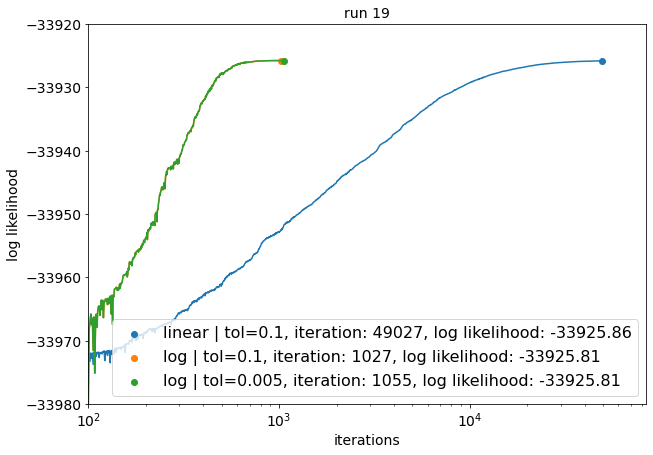

In [12]:
for j in range(20):
    filenames = []
    for out in out_dirs:
        iter_file, _ = get_minimization_file(out.format(j, j), params_config)
        filenames.append(iter_file)

    plot_minimization(filenames, plot_file=None, labels=labels, log='x', title='run {:d}'.format(j))
